In [17]:
import sys
import requests
import tarfile
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
import itertools as itt 
import re
from bs4 import BeautifulSoup as bs
from html import escape
from IPython.core.display import display, HTML
import json
%matplotlib inline

In [2]:
table_wrapper = '''<html>
<head>
<meta charset="UTF-8">
<style>
table, th, td {
 border: 1px solid black;
 font-size: 10px;
}
</style>
</head>
<body>
<table frame="hsides" rules="groups" width="100%%">
 %s
</table>
</body>
</html>'''

In [3]:
import webdataset as wds

In [7]:
dataset = wds.WebDataset("pubtabnet/pubtabnet-train-000000.tar").decode(only="json")

In [8]:
sample = next(iter(dataset))
sample.keys()

dict_keys(['__key__', 'json', 'png'])

In [48]:
def html_code_to_cells(html_code):
    remove = "<thead> </thead> <tbody> </tbody> </tr>".split()
    tokens = [x for x in html_code if x not in remove]
    rows = [list(y) for x, y in itt.groupby(tokens, lambda x: x.startswith("<tr")) if not x]
    cells = []
    
    i = 0
    for row in rows:
        cols = [list(y) for x, y in itt.groupby(row, lambda x: x.startswith("</td")) if not x]
        j = 0
        for col in cols:
            assert col[0].startswith("<td")
            bbox = re.search(r"bbox ([0-9 ]+)", col[0])
            if bbox is not None:
                bbox = bbox.group(1)
                bbox = list(map(int, bbox.split()))
            start = 0
            while not col[start].endswith(">"):
                start += 1
            start += 1
            cells.append(dict(row=i, col=j, bbox=bbox, tokens=col[start:]))
            rowspan = re.search(r"""rowspan=["']?(\d+)['"]?""", col[0])
            if rowspan:
                rowspan = int(rowspan.group(1))
                j += rowspan
            else:
                j += 1
        i += 1
    return cells

In [58]:
def decode_table(img):
    html_code = img["html"]["structure"]["tokens"].copy()
    to_insert = [i for i, tag in enumerate(html_code) if tag in ('<td>', '>')]
    for i, cell in zip(to_insert[::-1], img['html']['cells'][::-1]):
        if cell['tokens']:
            if "bbox" in cell:
                bbox = " ".join([str(x) for x in cell["bbox"]])
            else:
                bbox = None
            cell = [escape(token) if len(token) == 1 else token for token in cell['tokens']]
            cell = ''.join(cell)
            # cell = f"""<span class=ocr_cell title='bbox {bbox}'>{cell}</span>"""
            if html_code[i] == "<td>":
                html_code[i] = f"""<td title="bbox {bbox}">"""
            elif html_code[i] == ">":
                html_code[i] = f"""title="bbox {bbox}">"""
            html_code.insert(i + 1, cell)

    #cells = html_code_to_cells(html_code)
    html_string = ''.join(html_code)
    html_string = table_wrapper % html_string
    soup = bs(html_string)
    html_string = soup.prettify()
    return html_string

html_string = decode_table(sample["json"])
display(HTML(html_string))

In [65]:
url = "pubtabnet/pubtabnet-train-000000.tar"
def add_hocr(fname, out):
    assert not os.path.exists(out)
    sink = wds.TarWriter("temp.tar")
    dataset = wds.WebDataset(url).decode(only="json")
    for i, sample in enumerate(dataset):
        #print(sample["__key__"])
        sample["hocr.html"] = decode_table(sample["json"])
        sink.write(sample)
    sink.close()
    os.rename("temp.tar", out)

In [66]:
import glob
import os
fnames = glob.glob("pubtabnet/pubtabnet-*[0-9].tar")
for fname in fnames:
    out = os.path.splitext(fname)[0]+"-hocr.tar"
    if os.path.exists(out):
        continue
    print(fname, out)
    add_hocr(fname, out)

pubtabnet/pubtabnet-test-000000.tar pubtabnet/pubtabnet-test-000000-hocr.tar
pubtabnet/pubtabnet-train-000000.tar pubtabnet/pubtabnet-train-000000-hocr.tar
pubtabnet/pubtabnet-train-000001.tar pubtabnet/pubtabnet-train-000001-hocr.tar
pubtabnet/pubtabnet-train-000002.tar pubtabnet/pubtabnet-train-000002-hocr.tar
pubtabnet/pubtabnet-train-000003.tar pubtabnet/pubtabnet-train-000003-hocr.tar
pubtabnet/pubtabnet-train-000004.tar pubtabnet/pubtabnet-train-000004-hocr.tar
pubtabnet/pubtabnet-train-000005.tar pubtabnet/pubtabnet-train-000005-hocr.tar
pubtabnet/pubtabnet-train-000006.tar pubtabnet/pubtabnet-train-000006-hocr.tar
pubtabnet/pubtabnet-train-000007.tar pubtabnet/pubtabnet-train-000007-hocr.tar
pubtabnet/pubtabnet-train-000008.tar pubtabnet/pubtabnet-train-000008-hocr.tar
pubtabnet/pubtabnet-train-000009.tar pubtabnet/pubtabnet-train-000009-hocr.tar
pubtabnet/pubtabnet-train-000010.tar pubtabnet/pubtabnet-train-000010-hocr.tar
pubtabnet/pubtabnet-train-000011.tar pubtabnet/pubtabn

In [74]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [103]:
fnames = glob.glob("pubtabnet/pubtabnet-*[0-9]-hocr.tar")
dataset = wds.WebDataset(fnames[10]).decode("l")
it = next(islice(iter(dataset), 10, 9999999))

NameError: name 'islice' is not defined

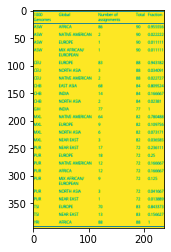

In [80]:
imshow(it["png"])

In [82]:
display(HTML(it["hocr.html"].decode("utf-8")))

1000 Genomes,Global,Number of assignments,Total,Fraction
ASW,AFRICA,86,90,0.955556
ASW,NATIVE AMERICAN,2,90,0.022222
ASW,EUROPE,1,90,0.011111
ASW,MIX AFRICAN/EUROPEAN,1,90,0.011111
CEU,EUROPE,83,88,0.943182
CEU,NORTH ASIA,3,88,0.034091
CEU,NATIVE AMERICAN,2,88,0.022727
CHB,EAST ASIA,68,84,0.809524
CHB,INDIA,14,84,0.166667
CHB,NORTH ASIA,2,84,0.02381


In [84]:
soup = bs(it["hocr.html"])

In [92]:
table = soup.find("table")

In [102]:
for row in table.findAll("tr"):
    print(row.name, row.attrs)
    cells = row.findAll("td")
    print(cells[0].find(text=True), cells[0].name, cells[0].attrs)

tr {}
1000 Genomes td {'title': 'bbox 1 4 33 22'}
tr {}
ASW td {'title': 'bbox 1 26 17 35'}
tr {}
ASW td {'title': 'bbox 1 40 17 49'}
tr {}
ASW td {'title': 'bbox 1 54 17 63'}
tr {}
ASW td {'title': 'bbox 1 68 17 77'}
tr {}
CEU td {'title': 'bbox 1 91 16 100'}
tr {}
CEU td {'title': 'bbox 1 105 16 114'}
tr {}
CEU td {'title': 'bbox 1 119 16 128'}
tr {}
CHB td {'title': 'bbox 1 133 16 142'}
tr {}
CHB td {'title': 'bbox 1 147 16 156'}
tr {}
CHB td {'title': 'bbox 1 161 16 170'}
tr {}
GIH td {'title': 'bbox 1 175 14 184'}
tr {}
MXL td {'title': 'bbox 1 189 17 198'}
tr {}
MXL td {'title': 'bbox 1 203 17 212'}
tr {}
MXL td {'title': 'bbox 1 217 17 226'}
tr {}
MXL td {'title': 'bbox 1 231 17 240'}
tr {}
PUR td {'title': 'bbox 1 245 16 254'}
tr {}
PUR td {'title': 'bbox 1 259 16 268'}
tr {}
PUR td {'title': 'bbox 1 273 16 282'}
tr {}
PUR td {'title': 'bbox 1 287 16 296'}
tr {}
PUR td {'title': 'bbox 1 301 16 310'}
tr {}
PUR td {'title': 'bbox 1 324 16 333'}
tr {}
PUR td {'title': 'bbox 1 338 